# Stopping track dQ/dx

The *stopping power* of a particle usually refers to the energy loss rate $dE/dx$ when it passes through matter. When charged particles travel through our LArTPC detector, they interact with the argon and lose energy.

## MIP and Bragg peak¶

Minimally ionizing particles (MIP) are charged particles which lose energy when passing through matter at a rate close to minimal. Particles such as muons often have energy losses close to the MIP level and are treated in practice as MIP. The only exception is when the muon comes to a stop and experiences a Bragg peak.

<figure>
<img src="bragg_peak.png" style="width:600px">
<figcaption align = "center"> Example of muon Bragg peak. The muon is travelling from bottom left to top right. The color scale represents energy deposition. Red means more energy deposited. The sudden increase in deposited (lost) energy towards the end of the muon trajectory is the Bragg peak. From MicroBooNE (arxiv: 1704.02927) </figcaption>
</figure>

## I. Motivation

We know that the energy loss rate of a MIP in argon is ~2 MeV/cm. Hence our goal is to carefully isolate the MIP-like sections of muons (i.e. leaving out the ends of the track), and compute the (reconstructed) energy loss along these trajectories $dQ/dx$. This can inform the detector calibration effort, for example, since we can compare the peak of the $dQ/dx$ histogram with the theoretical expected value (although there are many detector effects that make this not straightforward). We can also study the spatial uniformity of the detector by looking at MIP $dQ/dx$ values in different regions of the detector, etc. If we plot the dQ/dx change along the so-called "residual range" (i.e. distance to the end of the muon trajectory), we get a characteristic plot (due to the Bragg peak). In this tutorial we will focus on reproducing this plot.

<figure>
<img src="residual_range.png" style="width:600px">
<figcaption align = "center"> Example of what we expect for a track dQ/dx versus residual range 2d histogram. The sudden increase in deposited (lost) energy towards the end of the muon trajectory (= low residual range) is the Bragg peak. From MicroBooNE (arxiv: 2010.02390) </figcaption>
</figure>

## II. Setup

Again, we start by setting our working environment. Some necessary boilerplate code:

### a. Software and data directory

In [44]:
import os, sys

# SOFTWARE_DIR = '/sdf/data/neutrino/software/spine' # Change this path to your software install
SOFTWARE_DIR = '/sdf/group/neutrino/drielsma/dev/spine' # Change this path to your software install
DATA_DIR = '/sdf/data/neutrino/public_html/spine_workshop/' # Change this path if you are not on SDF (see main README)

# Set software directory
sys.path.insert(0, SOFTWARE_DIR)

### b. Numpy, Matplotlib, and Plotly for Visualization and data handling.

In [45]:
# Basic boilerplate imports
import numpy as np
import pandas as pd
import yaml, os, sys, re

# Visualization Tools
import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import matplotlib.pyplot as plt
import seaborn as sns

### c. MLRECO specific imports for model loading and configuration setup

Let’s parse the analysis configuration file `anaconfig.cfg` to load the reconstruction output. This file uses the keyword `DATA_DIR` to symbolize the path to reconstructruted dataset. We need to replace it with the actual location defined previously.

In [46]:
# Load anatools config file
# Replace the source file with the correct path
DATA_PATH = DATA_DIR + 'reco/generic_small_spine.h5'
anaconfig = '../../anaconfig.cfg' # Inside the main directory
anaconfig = yaml.safe_load(open(anaconfig, 'r').read().replace('DATA_PATH', DATA_PATH))

Let’s parse the analysis configuration file `anaconfig.cfg` to load the reconstruction output. This file uses the keyword `DATA_DIR` to symbolize the path to reconstructruted dataset. We need to replace it with the actual location defined previously.

In [47]:
# Initialize Anatools manager
from spine.driver import Driver

driver = Driver(anaconfig)


 ██████████   ██████████    ███   ███       ██   ███████████
███        █  ██       ███   █    █████     ██   ██         
  ████████    ██       ███  ███   ██  ████  ██   ██████████ 
█        ███  ██████████     █    ██     █████   ██         
 ██████████   ██            ███   ██       ███   ███████████

Release version: 0.1.0

$CUDA_VISIBLE_DEVICES=

Configuration processed at: Linux sdfampere027 4.18.0-372.32.1.el8_6.x86_64 #1 SMP Fri Oct 7 12:35:10 EDT 2022 x86_64 x86_64 x86_64 GNU/Linux

base: {seed: 1721540045}
io:
  reader: {name: hdf5, file_keys: /sdf/data/neutrino/public_html/spine_workshop/reco/generic_small_spine.h5}
build: {mode: both, units: cm, fragments: false, particles: true, interactions: true}

Will load 1 file(s):
  - /sdf/data/neutrino/public_html/spine_workshop/reco/generic_small_spine.h5

Total number of entries in the file(s): 6

Total number of entries selected: 6



We are now all set to load **one iteration** of the reconstruction output as follows:

### d. Load data/reconstruction output

We are now all set to load **one iteration** of the reconstruction output as follows:

In [48]:
ENTRY_NUM = 3
data = driver.process(entry=ENTRY_NUM)

The input data and label information are loaded onto the `data` variable, while the outputs from the chain are stored inside `result`. We will use the output of this single iteration to demonstrate a simple Michel electron selection, before running with higher statistics (ie. performing many more iterations).

Now we load the true and reconstucted ``Particle`` objects:

In [49]:
reco_particles = data['reco_particles']
truth_particles = data['truth_particles']

## III. Visualize true and predicted particles

Let’s first import plotting functions from `lartpc_mlreco3d` for easier visualization:

In [50]:
from spine.vis.out import Drawer
from spine.vis.point import scatter_points
from spine.vis.layout import PLOTLY_COLORS_WGRAY, layout3d

The evaluator will handle ghost masking internally, so all you have to do is retrieve the predicted and true semantic segmentation labels for visualization and analysis:

By default, the label for tracks and michel electrons are 1 and 2, respectively.

In [51]:
from spine.utils.enums import ShapeEnum

list(ShapeEnum)

[<ShapeEnum.SHOWER: 0>,
 <ShapeEnum.TRACK: 1>,
 <ShapeEnum.MICHEL: 2>,
 <ShapeEnum.DELTA: 3>,
 <ShapeEnum.LOWE: 4>,
 <ShapeEnum.GHOST: 5>]

In [52]:
drawer = Drawer(data)

fig = drawer.get('particles', attr='shape')

fig.show()

The predicted particles, each color-coded according to its semantic type, will be displayed in left; the true particles on right.

## I. Select stopping muons
We will select track-like predicted particles that are close to a Michel predicted particle.
For the stopping muon residual range study purpose, purity is more important than efficiency.
Hence we only select stopping muons that decay into a Michel electron.

In [53]:
from scipy.spatial.distance import cdist

def get_stopping_muons(particles, Michel_threshold=10):
    selected_muons = []
    closest_points = []

    # Loop over predicted particles
    for p in particles:
        if p.shape != ShapeEnum.TRACK: continue
        coords = p.points

        # Check for presence of Michel electron
        attached_to_Michel = False
        closest_point = None
        for p2 in particles:
            if p2.shape != ShapeEnum.MICHEL: continue
            d =  cdist(p.points, p2.points)
            if d.min() >= Michel_threshold: continue
            attached_to_Michel = True
            closest_point = d.min(axis=1).argmin()

        if not attached_to_Michel: continue

        selected_muons.append(p)
        closest_points.append(closest_point)

    return selected_muons, closest_points

In [54]:
selected_muons, closest_points = get_stopping_muons(reco_particles)
for part in selected_muons:
    print(part)

RecoParticle(ID: 6   | PID: Muon     | Primary: 1  | Size: 719   | Match: 10 )


And just as a sanity check, let's run the same function on the true particles to ensure it selects what we expect:

In [55]:
for part in get_stopping_muons(truth_particles)[0]:
    print(part)

TruthParticle(ID: 10  | PID: Muon     | Primary: 1  | Size: 721   | Match: 6  )


## II. Muon direction with PCA
Once we have a suitable muon selected, the next step is to bin it. To make the binning easier, we will find the approximate direction of the muon using principal component analysis (PCA) then project all muon voxels along this axis.

In [56]:
from sklearn.decomposition import PCA

def get_PCA(particles):
    pca = PCA(n_components=1)
    pca_coordinates = []
    pca_directions = []
    for p in particles:
        coords = p.points
        # PCA to get a rough direction
        coords_pca = pca.fit_transform(p.points)[:]
        pca_coordinates.append(coords_pca.flatten())
        pca_directions.append(pca.components_[0])

    return pca_coordinates, pca_directions

Time to run our function on the muon we just selected:

In [57]:
pca_coordinates, pca_directions = get_PCA(selected_muons)

It is always a good idea to visualize the output of each intermediate stage to make sure the output is not garbage for the next step. The muon voxels are in blue, the computed PCA direction is in orange.

In [58]:
trace = []

for idx, (coords, direction) in enumerate(zip(pca_coordinates, pca_directions)):
    trace += scatter_points(selected_muons[idx].points,
                            markersize=1,
                            color='blue')

    # Artificially create a point cloud for the PCA direction visualization
    pca_points = selected_muons[idx].points[coords.argmin()][None, :] + direction[None, :] * (coords[:, None]-coords.min())
    trace += scatter_points(pca_points,
                            markersize=1,
                            color='orange')

fig = go.Figure(data=trace, layout=layout3d(meta=data['meta'], detector_coords=True))
iplot(fig)

The orange direction seems to match *roughly* the muon direction, so we can move on to the next step.

## III Local dQ/dx

Using the rough muon direction, we will define segments by binning the projection of all voxels onto this axis.

In [59]:
def get_dQdx(particles, closest_points, pca_coordinates,
             bin_size=5, # cm
             return_pca=False):

    df = {
        "dQ": [],
        "dx": [],
        "residual_range": []
    }

    pca = PCA(n_components=1)

    list_coords, list_pca, list_directions = [], [], []
    for p, closest_point, coords_pca in zip(particles, closest_points, pca_coordinates):
        coords = p.points

        # Make sure where the end vs start is
        # if end == 0 we have the right bin ordering, otherwise might need to flip when we record the residual range
        distances_endpoints = [((coords[coords_pca.argmin(), :] - coords[closest_point, :])**2).sum(), ((coords[coords_pca.argmax(), :] - coords[closest_point, :])**2).sum()]
        end = np.argmin(distances_endpoints)

        # Split into segments and compute local dQ/dx
        if not end: # no need to flip
            bins = np.arange(coords_pca.min(), coords_pca.max(), bin_size)
            bin_inds = np.digitize(coords_pca, bins)
        else: # must flip
            bins = np.arange(-coords_pca.max(), -coords_pca.min(), bin_size)
            bin_inds = np.digitize(-coords_pca, bins)

        for i in np.unique(bin_inds):
            mask = bin_inds == i
            if np.count_nonzero(mask) < 2: continue

            # Repeat PCA locally for better measurement of dx
            pca_axis = pca.fit_transform(p.points[mask])
            list_coords.append(p.points[mask])
            list_pca.append(pca_axis.flatten())
            list_directions.append(pca.components_[0])

            dx = pca_axis[:, 0].max() - pca_axis[:, 0].min()
            dQ = p.depositions[mask].sum()
            residual_range = ((i - 0.5) * bin_size)

            df["dx"].append(dx)
            df["dQ"].append(dQ)
            df["residual_range"].append(residual_range)

    df = pd.DataFrame(df)

    if return_pca:
        return list_coords, list_pca, list_directions

    return df     

For each segment, we compute
* dQ (sum of reconstructed charge of all voxels in the segment)
* dx (for better precision we recompute a local PCA direction on the segment voxels exclusively)
* residual range (distance from the muon end, well-defined using the Michel contact point)

In [60]:
get_dQdx(selected_muons, closest_points, pca_coordinates)

,dQ,dx,residual_range
0,29.278297,4.815865,2.5
1,18.699163,4.871116,7.5
2,13.737882,4.624879,12.5
3,12.611551,4.874074,17.5
4,12.292276,4.845059,22.5
5,12.222911,4.917746,27.5
6,9.927843,4.576751,32.5
7,11.118335,4.919302,37.5
8,12.258119,4.588553,42.5
9,11.168406,4.891025,47.5


Once again, let's take the time to visualize the binning and make sure the segments make sense. The black voxels belong to the local PCA directions, the colored voxels belong to different segments (color = segment id).

In [61]:
import matplotlib.pyplot as plt
trace = []

list_coords, list_pca, list_directions = get_dQdx(selected_muons, closest_points, pca_coordinates, return_pca=True)
cmap = plt.cm.get_cmap('Set1')
n = len(list_coords)
for idx, (coords, pca_axis, direction) in enumerate(zip(list_coords, list_pca, list_directions)):
    trace += scatter_points(coords,
                            markersize=2,
                            color='rgb%s' % str(cmap(idx/n)[:-1]))
    #print(direction[None, :] * coords[:, None])
    #print(cmap(idx/n))
    pca_points = coords[pca_axis.argmin()][None, :] + direction[None, :] * (pca_axis[:, None]-pca_axis.min())
    trace += scatter_points(pca_points,
                           markersize=2,
                           color='black')


fig = go.Figure(data=trace,layout=layout3d(meta=data['meta'], detector_coords=True))
iplot(fig)

## IV. Repeat with high statistics
We have computed everything we want, we just need to repeat this with higher statistics.

In [62]:
muons = pd.DataFrame({
        "index": [],
        "dQ": [],
        "dx": [],
        "residual_range": []
    })

from tqdm import tqdm
for iteration in tqdm(range(100)):
    if iteration >= len(driver):
        break
    data = driver.process(entry=iteration)
    index = data['index']
    
    reco_particles = data['reco_particles']
    # truth_particles = data['truth_particles']

    selected_muons, closest_points = get_stopping_muons(reco_particles)
    pca_coordinates, pca_directions = get_PCA(selected_muons)
    df = get_dQdx(selected_muons, closest_points, pca_coordinates)
    df['index'] = index
    muons = pd.concat([muons, df])

  6%|▌         | 6/100 [00:00<00:02, 33.99it/s]


In [63]:
muons

,index,dQ,dx,residual_range
0,0.0,27.349108,4.956691,2.5
1,0.0,15.128755,4.656952,7.5
2,0.0,14.930378,4.837129,12.5
3,0.0,11.480001,4.586117,17.5
4,0.0,11.171758,4.596209,22.5
...,...,...,...,...
31,3.0,9.674087,4.867632,157.5
32,3.0,8.851459,4.590640,162.5
33,3.0,9.788578,4.845227,167.5
34,3.0,9.936487,4.539036,172.5


## Plot dQ/dx vs residual range

In [64]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn
seaborn.set(rc={
    'figure.figsize':(15, 10),
})
seaborn.set_context('talk')

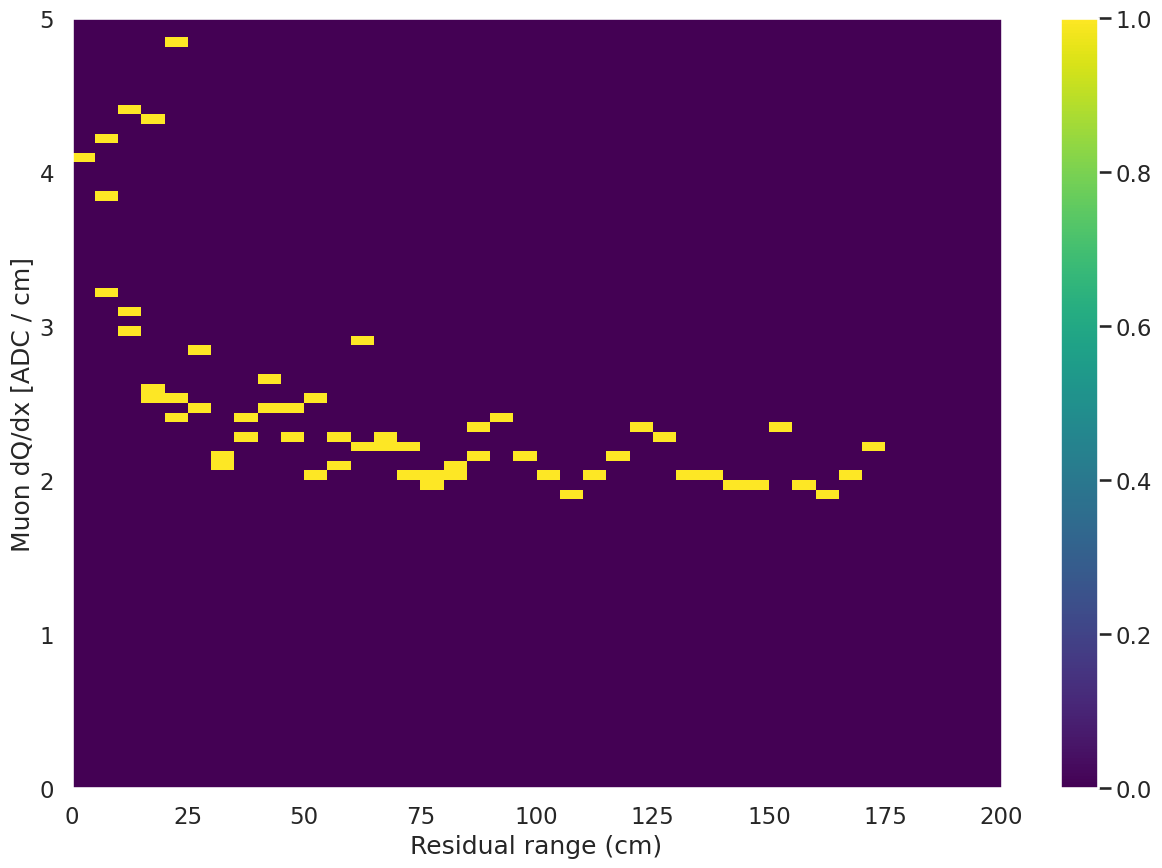

In [68]:
clean = (muons["dx"] > 3.5) & (muons["dx"] < 50) #& (cells['pca_length'] > 150)
#clean = np.ones(shape=muons["residual_range"].shape, dtype=np.bool)
plt.hist2d(muons["residual_range"][clean], muons["dQ"][clean]/(muons["dx"][clean]),
          # range=[[0, 200], [0, 2000]], bins=[40, 80],
          range=[[0, 200], [0, 5]], bins=[40, 80],
          cmap="viridis")
plt.colorbar()
plt.xlabel("Residual range (cm)")
plt.ylabel("Muon dQ/dx [ADC / cm]")
plt.show()

## V. Exercises

- Undesrtand and remove contribution from misreconstructed muons
  - Check event displays for events with wild outliers
  - Identify specific reconstruction issue
  - Introduce some selection to get rid of them
- Compute the mean/std for each residual range bin
- Repeat the above using `truth_particles` instead
  - Use `truth_particle.truth_depositions_MeV`
  - Compare the dE/dx vs. residual range to expectation
- Run on larger statistics
- Try it out with your favorite detector by changing the input file!
  
  